In [24]:
import torch
import torch.nn as nn
import torch.optim as optim

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

[*********************100%%**********************]  1 of 1 completed

Date
2024-01-08    138.839996
2024-01-09    140.949997
2024-01-10    142.279999
2024-01-11    142.080002
2024-01-12    142.649994
Name: Close, dtype: float64


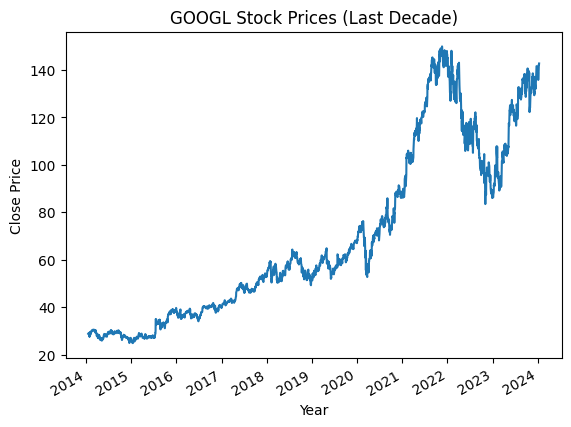

In [25]:
import yfinance as yf
import pandas as pd

from datetime import datetime, timedelta

# replace with stock indicator
stock = 'GOOGL'

# date setters, start date 10 years ago end date now
startDate = datetime.now() - timedelta(days=365*10)
endDate = datetime.now()

# extract historical stock prices from yfinance, take only close
prices = yf.download(stock, start=startDate, end=endDate)
prices = prices['Close']

# print recent prices in table head
print(prices.tail())

# plot prices in plot
prices.plot(title=f'{stock} Stock Prices (Last Decade)')
plt.xlabel('Year')
plt.ylabel('Close Price')
plt.show()

# Split Train and Test
The train and test sets will be split into the following:

1. The training set will be the first 9 years.
2. The testing set will be the past year.

In [26]:
def train_test_split(prices):
    length = len(prices)

    # split point is 9 years in or 9/10 of the length, round to the nearest integer
    splitPoint = round(0.9 * length)

    # differentiate into train and test 
    train = prices[:splitPoint]
    test = prices[splitPoint:]

    return train, test

train_set, test_set = train_test_split(prices)

print(train_set.tail())
print(test_set.tail())

# switch training and testing sets to torch Tensors
train_set = torch.tensor(train_set)
test_set = torch.tensor(test_set)

Date
2023-01-06    87.339996
2023-01-09    88.019997
2023-01-10    88.419998
2023-01-11    91.519997
2023-01-12    91.129997
Name: Close, dtype: float64
Date
2024-01-08    138.839996
2024-01-09    140.949997
2024-01-10    142.279999
2024-01-11    142.080002
2024-01-12    142.649994
Name: Close, dtype: float64


The model will have one layer 128 LSTM cells, as we are taking univariate input

In [30]:
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM, self).__init__()
        self.hidden_dim = hidden_dim

        # LSTM layer
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)

        # readout layer
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # initialize hidden states with zeroes
        h0 = torch.zeros(self.num_layers, input.size(0), self.hidden_size).requires_grad_()

        # initialize cell state
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).requires_grad_()

        # detach
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))

# set model 
model = LSTM(1, 128, 1, 1)

In [ ]:
def trainingLoop():
    
